# Odds and ends

## Feature importance

In [66]:
%matplotlib inline
# Imports and variables
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import unicodedata
import warnings

from itertools import groupby
from nltk.chunk import RegexpParser, tree2conlltags
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from unicodedata import category as unicat

# Import our corpus readers
sys.path.append(os.path.join('..', 'libraries'))
import TMN

# File locations
pkl_dir = os.path.join('..', 'data', 'pickled')
txt_dir = os.path.join('..', 'data', 'texts')
wordlist_dir = os.path.join('..', 'data', 'wordlists')

# Plotting settings
plt.rcParams['figure.figsize'] = [12, 8]

In [68]:
# Set up corpus reader
corpus = TMN.TMNCorpusReader(txt_dir)

# Get class labels ('A' or 'B')
labels = [corpus.categories(fileids=fileid)[0] for fileid in corpus.fileids()]

# Set up vectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    min_df=3, 
    max_df=0.7
)

# Perform vectorization
features = vectorizer.fit_transform(corpus.docs())

# Retrieve list of features names (e.g., "dog", "cat")
feature_names = vectorizer.get_feature_names()

# Scale features
features = StandardScaler().fit_transform(features.todense())

# Set up classifier
clf = LogisticRegression(
    solver='liblinear'
)

# Cross validate for informational purposes
print("Cross-validation score:", np.mean(cross_val_score(clf, features, labels, cv=10)))

# Fit classifier to all data
clf.fit(features, labels)

# Score final classifier
print("Full model 'accuracy':", clf.score(features, labels)) # Very high due to overfitting (not cross validated)

# Get class probabilities
print("\n Class probability (A, B)")
print(clf.predict_proba(features))

# Assess feature importance
idx = np.argsort(clf.coef_) # Get indicies of sorted classifier coefficients
feature_importance = np.array(feature_names)[idx] # Sort coefficients
print("\nTop American features")
for i in range(20):
    print(f'\t{feature_importance[0][i]}\t\t({round(clf.coef_[0][idx[0][i]], 3)})')
print('\nTop British features')
for i in range(1,21):
    print(f'\t{feature_importance[0][-i]}\t\t({round(clf.coef_[0][idx[0][-i]], 3)})')

Cross-validation score: 0.825
Full model 'accuracy': 1.0

 Class probability (A, B)
[[9.98956992e-01 1.04300820e-03]
 [9.99874206e-01 1.25793800e-04]
 [9.99721608e-01 2.78391694e-04]
 [9.99808979e-01 1.91020773e-04]
 [9.99766575e-01 2.33424576e-04]
 [9.99713493e-01 2.86507028e-04]
 [9.99144820e-01 8.55180413e-04]
 [9.99642810e-01 3.57190049e-04]
 [9.99868529e-01 1.31471346e-04]
 [9.99725016e-01 2.74984413e-04]
 [9.99629309e-01 3.70691405e-04]
 [9.99714327e-01 2.85673380e-04]
 [9.99548039e-01 4.51960728e-04]
 [9.99683405e-01 3.16594770e-04]
 [9.99712486e-01 2.87513948e-04]
 [9.99667126e-01 3.32873958e-04]
 [9.99723095e-01 2.76904580e-04]
 [9.99663665e-01 3.36334885e-04]
 [9.99797123e-01 2.02876731e-04]
 [9.99448233e-01 5.51766587e-04]
 [5.29353689e-04 9.99470646e-01]
 [1.06879981e-04 9.99893120e-01]
 [2.14850320e-04 9.99785150e-01]
 [9.92034107e-05 9.99900797e-01]
 [2.47670389e-04 9.99752330e-01]
 [2.66486960e-04 9.99733513e-01]
 [9.12089660e-05 9.99908791e-01]
 [2.74491718e-04 9.997255

## Simple sentiment analysis

### Dictionary-based

In [79]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Demo data from the documentation
sentences = [
    "VADER is smart, handsome, and funny.", # positive sentence example
    "VADER is smart, handsome, and funny!", # punctuation emphasis handled correctly (sentiment intensity adjusted)
    "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
    "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
    "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
    "VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!",# booster words & punctuation make this close to ceiling for score
    "The book was good.",         # positive sentence
    "The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
    "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
    "A really bad, horrible book.",       # negative sentence with booster words
    "At least it isn't a horrible book.", # negated negative sentence with contraction
    ":) and :D",     # emoticons handled
    "",              # an empty string is correctly handled
    "Today sux",     #  negative slang handled
    "Today sux!",    #  negative slang with punctuation emphasis handled
    "Today SUX!",    #  negative slang with capitalization emphasis
    "Today kinda sux! But I'll get by, lol" # mixed sentiment example with slang and constrastive conjunction "but"
]

sa = SentimentIntensityAnalyzer()
for sentence in sentences:
    print(sentence)
    scores = sa.polarity_scores(sentence)
    for key in sorted(scores):
         print('{0}: {1}, '.format(key, scores[key]))
    print()

VADER is smart, handsome, and funny.
compound: 0.8316, 
neg: 0.0, 
neu: 0.254, 
pos: 0.746, 

VADER is smart, handsome, and funny!
compound: 0.8439, 
neg: 0.0, 
neu: 0.248, 
pos: 0.752, 

VADER is very smart, handsome, and funny.
compound: 0.8545, 
neg: 0.0, 
neu: 0.299, 
pos: 0.701, 

VADER is VERY SMART, handsome, and FUNNY.
compound: 0.9227, 
neg: 0.0, 
neu: 0.246, 
pos: 0.754, 

VADER is VERY SMART, handsome, and FUNNY!!!
compound: 0.9342, 
neg: 0.0, 
neu: 0.233, 
pos: 0.767, 

VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!
compound: 0.9469, 
neg: 0.0, 
neu: 0.294, 
pos: 0.706, 

The book was good.
compound: 0.4404, 
neg: 0.0, 
neu: 0.508, 
pos: 0.492, 

The book was kind of good.
compound: 0.3832, 
neg: 0.0, 
neu: 0.657, 
pos: 0.343, 

The plot was good, but the characters are uncompelling and the dialog is not great.
compound: -0.7042, 
neg: 0.327, 
neu: 0.579, 
pos: 0.094, 

A really bad, horrible book.
compound: -0.8211, 
neg: 0.791, 
neu: 0.209, 
pos: 0.0, 

At 

In [87]:
%%time
# Run over our corpus
vader_results = {}
for fileid in corpus.fileids():
    score = 0.0
    sentence_count = 0
    for sent in corpus.sents(fileids=fileid):
        score += sa.polarity_scores(sent)['compound']
        sentence_count += 1
    vader_results[fileid] = score/sentence_count

CPU times: user 1min 32s, sys: 550 ms, total: 1min 33s
Wall time: 1min 35s


In [104]:
v = sorted(vader_results, key=vader_results.get, reverse=True)
for key in v:
    print(f'{key}:\t\t{round(vader_results[key], 5)}')

B-Mitford-Our_Village-1826-F.txt:		0.23795
A-Alcott-Little_Women-1868-F.txt:		0.18838
A-Jewett-Pointed_Firs-1896-F.txt:		0.17409
B-Austen-Pride_Prejudice-1813-F.txt:		0.15301
A-Gilman-Herland-1915-F.txt:		0.14754
B-Thackeray-Vanity_Fair-1848-M.txt:		0.14077
A-James-Golden_Bowl-1904-M.txt:		0.1403
B-Disraeli-Sybil-1845-M.txt:		0.10504
B-Dickens-Bleak_House-1853-M.txt:		0.10112
B-Eliot-Middlemarch-1869-F.txt:		0.0919
A-Wharton-Age_Innocence-1920-F.txt:		0.08428
A-Chopin-Awakening-1899-F.txt:		0.08147
A-Cather-Antonia-1918-F.txt:		0.07856
B-Burney-Evelina-1778-F.txt:		0.07503
A-Dreiser-Sister_Carrie-1900-M.txt:		0.06893
A-Stowe-Uncle_Tom-1852-F.txt:		0.06788
B-Trollope-Live_Now-1875-M.txt:		0.06548
A-Hawthorne-Scarlet_Letter-1850-M.txt:		0.06319
A-Howells-Silas_Lapham-1885-M.txt:		0.06185
B-Woolf-Mrs_Dalloway-1925-F.txt:		0.06104
B-Bronte_C-Jane_Eyre-1847-F.txt:		0.05824
A-Norris-Pit-1903-M.txt:		0.05611
B-Gaskell-North_South-1855-F.txt:		0.05031
B-Gissing-Grub_Street-1893-M.txt:		0.04906

### Pretrained classifier

Need `textblob` library installed. From the command line:

```
conda install -c conda-forge textblob
```

In [128]:
%%time
# Run over our corpus
textblob_results = {}
for fileid in corpus.fileids():
    score = 0.0
    sentence_count = 0
    for doc in corpus.docs(fileids=fileid):
        blob = TextBlob(doc)
        for sent in blob.sentences:
            score += sent.sentiment.polarity
            sentence_count += 1
    textblob_results[fileid] = score/sentence_count

CPU times: user 1min 48s, sys: 1.36 s, total: 1min 49s
Wall time: 1min 55s


In [106]:
t = sorted(textblob_results, key=textblob_results.get, reverse=True)
for key in t:
    print(f'{key}:\t\t{round(textblob_results[key], 5)}')

A-Gilman-Herland-1915-F.txt:		0.12291
B-Mitford-Our_Village-1826-F.txt:		0.12131
A-Jewett-Pointed_Firs-1896-F.txt:		0.10973
A-Alcott-Little_Women-1868-F.txt:		0.1024
B-Austen-Pride_Prejudice-1813-F.txt:		0.10197
A-James-Golden_Bowl-1904-M.txt:		0.08933
B-Thackeray-Vanity_Fair-1848-M.txt:		0.08612
A-Harper-Iola_Leroy-1892-F.txt:		0.07844
B-Disraeli-Sybil-1845-M.txt:		0.07791
B-Burney-Evelina-1778-F.txt:		0.07619
B-Eliot-Middlemarch-1869-F.txt:		0.07006
A-Stowe-Uncle_Tom-1852-F.txt:		0.0697
B-Shelley-Frankenstein-1818-F.txt:		0.06878
A-Chopin-Awakening-1899-F.txt:		0.06151
B-Dickens-Bleak_House-1853-M.txt:		0.06115
A-Howells-Silas_Lapham-1885-M.txt:		0.06114
B-Trollope-Live_Now-1875-M.txt:		0.05968
A-Hawthorne-Scarlet_Letter-1850-M.txt:		0.05874
A-Dreiser-Sister_Carrie-1900-M.txt:		0.0581
A-Twain-Huck_Finn-1885-M.txt:		0.0554
B-Radcliffe-Mysteries_Udolpho-1794-F.txt:		0.05493
A-Norris-Pit-1903-M.txt:		0.05435
B-Woolf-Mrs_Dalloway-1925-F.txt:		0.05402
B-Gissing-Grub_Street-1893-M.txt:		0.

### Sentiment method correlation by ranks

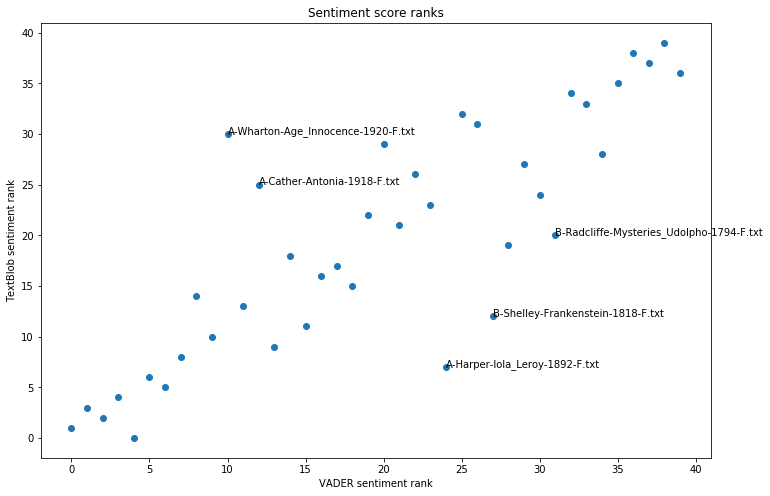

In [127]:
v_ranks = []
t_ranks = []

# Get index position in sorted lists
for fileid in corpus.fileids():
    v_ranks.append(v.index(fileid))
    t_ranks.append(t.index(fileid))

# Plot ranks, labeling outliers
fig, ax = plt.subplots()
ax.scatter(v_ranks, t_ranks)
for i, txt in enumerate(corpus.fileids()):
    if abs(abs(v_ranks[i]) - abs(t_ranks[i])) > 10:
        ax.annotate(txt, (v_ranks[i], t_ranks[i]))
plt.xlabel("VADER sentiment rank")
plt.ylabel("TextBlob sentiment rank")
plt.title("Sentiment score ranks")
plt.show()